In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

In [63]:
def adjust_graph_ends(x, y, frame_step=1):
    # Extract the first value from the existing array
    y_first_value = y[0]
    x_first_value = x[0]
    # Extract the last value from the existing array
    y_last_value = y[-1]
    x_last_value = x[-1]
    # Compute the new value as less than the current first value
    y_new_value = round(y_first_value * 0.99, 5)
    x_new_value = round(x_first_value - frame_step)
    # Compute the new value as less than the current first value
    y_new_value2 = round(y_last_value * 0.99, 5)
    x_new_value2 = round(x_last_value + frame_step)
    # Create a new array with the new value and concatenate it with the existing array
    y = np.concatenate(([y_new_value], y))
    y = np.concatenate((y, [y_new_value2]))
    x = np.concatenate(([x_new_value], x))
    x = np.concatenate((x, [x_new_value2]))
    return x, y

In [9]:
repeatsdb_df = pd.read_csv("../data/repeatsdb_unique_updated.csv", dtype={'ct': str})
repeatsdb_df

,region_id,uniprot,ctfc,units,units_num,units_avg,insertions,insertions_num,pdb,ct
0,4zb5A_11_311,P24300,4.5.0.0,"11_49,50_87,88_132,133_176,177_211,212_244,245...",8,36.62,NaN,0,4zb5A,4.5
1,5zbgA_24_171,Q13507,3.3.0,"24_53,54_87,88_116,117_171",4,36.00,121_149,1,5zbgA,3.3
2,2zb5A_215_606,P08362,4.4.0.0,"215_285,286_345,346_441,442_482,509_561,562_606",6,60.00,"372_408,483_508",2,2zb5A,4.4
3,4zb4A_188_502,P32523,4.4.0.0,"188_247,248_287,288_334,335_376,377_423,424_47...",7,44.00,NaN,0,4zb4A,4.4
4,2zb1A_8_108,Q16539,4.2.0,"8_23,24_47,88_108",3,19.33,48_87,1,2zb1A,4.2
...,...,...,...,...,...,...,...,...,...,...
2468,3ctlA_2_218,P32719,4.1.1.3,"2_27,28_59,60_81,82_107,108_129,130_167,168_18...",8,26.12,NaN,0,3ctlA,4.1
2469,5ctrA_307_586,Q15020,3.3.0.0,"307_341,342_376,377_411,412_469,470_506,507_53...",7,39.00,NaN,0,5ctrA,3.3
2470,5ltpA_6_215,A0A1S4NYF2,4.2.0,"6_31,32_94,95_127,148_179,190_215",5,35.00,"45_82,128_147,180_189",3,5ltpA,4.2
2471,5ltdA_33_524,Q5QA94,4.4.1,"33_72,73_120,121_159,160_224,225_269,270_452,4...",7,69.29,462_489,1,5ltdA,4.4


In [214]:
region_id = "4am9A_32_137"
graph_dir = "/home/soroushm/Documents/ML-TRP-Parser_workframe/dataframes/graph_tmscore_output"
instance_path = os.path.join(graph_dir, f"{region_id[1:3]}", f"{region_id}_vs_{region_id}_graph.csv")
instance_df = pd.read_csv(instance_path)
instance_df

,x_start,x_end,y
0,29,62,0.67160
1,30,63,0.68800
2,31,64,0.70756
3,32,65,0.73138
4,33,66,0.75793
...,...,...,...
101,130,163,0.53018
102,131,164,0.52964
103,132,165,0.52678
104,133,166,0.52573


In [215]:
x = np.array(instance_df["x_start"])
y = np.array(instance_df["y"])
length = instance_df.loc[0, "x_end"] - instance_df.loc[0, "x_start"] + 1 # Last residue is inclusive

In [216]:
units = repeatsdb_df[repeatsdb_df["region_id"] == region_id]["units"].values[0].split(",")
unit_start_list = [int(i.split("_")[0]) for i in units]

In [228]:
ct = str(repeatsdb_df[repeatsdb_df["region_id"] == region_id]["ct"].values[0])
ct

'3.3'

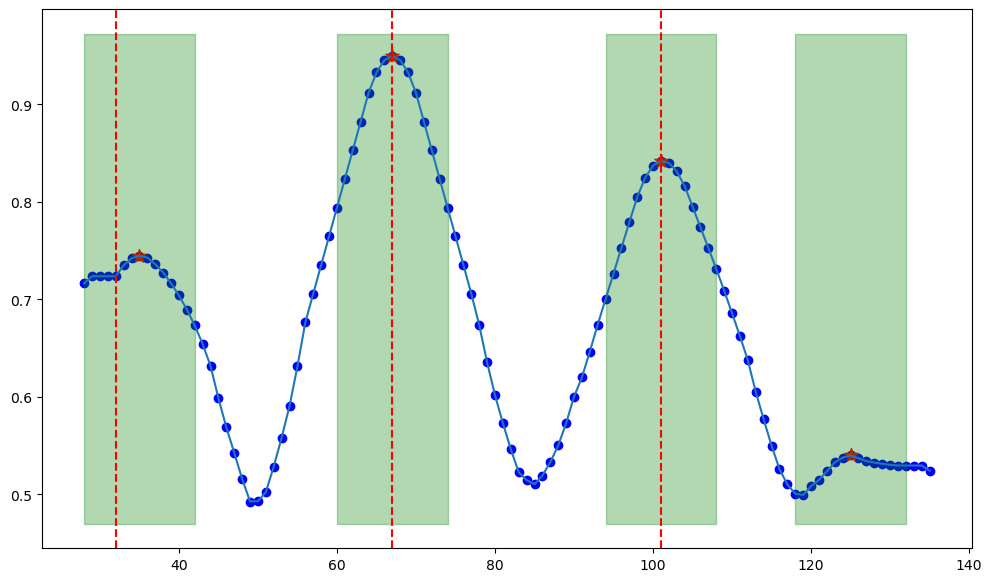

In [217]:
# Smooth the graph by 3 residue window size (smallest possible size --> reducing noise / not compromising resolution)
window_size = round(length * 0.2)
if window_size % 2 == 0:
    window_size -= 1
poly_order = 0
y = savgol_filter(y, window_size, poly_order)

x, y = adjust_graph_ends(x, y)

# Detect peaks and associated properties
peaks, properties = find_peaks(y, height=0.2, distance=round(length * 0.5),
                      threshold=0, prominence=0, width=0, plateau_size=0)

# Mark the peaks on y and x-axis
peaks_x = [x[peak_idx] for peak_idx in peaks]
peaks_y = [y[peak_idx] for peak_idx in peaks]

# Plot the results
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 7))
# Graph of all the residue vs tm-score points
ax.plot(x, y)
# Scatter of all the residue vs tm-score points
ax.scatter(x, y, marker='o', color='blue')
# Scatter of the detected peaks
ax.scatter(peaks_x, peaks_y, marker="*", color="red", s=100)
for unit_start in unit_start_list:
    ax.axvline(x=unit_start, color='r', linestyle='--')

lim_1 = ax.get_ylim()[1]
lim_2 = ax.get_ylim()[0]
highlight_range = round(length * 0.2)
for point in peaks_x:
    start_x = max(point - highlight_range, min(x))
    end_x = min(point + highlight_range, max(x))
    ax.fill_between([start_x, end_x], lim_1, lim_2, color='green', alpha=0.3)

plt.show()

In [274]:
peaks_df = pd.DataFrame(properties)
peaks_df["peak_x"] = peaks_x
column_list = ["left_edges", "right_edges", "left_ips", "right_ips", "left_bases", "right_bases"]
for column in column_list:
    peaks_df[column] = (peaks_df['peak_x'] - peaks_df[column]) / length

# Create shifted dataframes
peaks_df_previous1 = peaks_df.shift(1)
peaks_df_next1 = peaks_df.shift(-1)

# Rename columns
peaks_df_previous1.columns = ['pre1_' + col for col in peaks_df.columns]
peaks_df_next1.columns = ['post1_' + col for col in peaks_df.columns]

# Concatenate
peaks_df = pd.concat([peaks_df_previous1, peaks_df, peaks_df_next1], axis=1)
peaks_df.fillna(0, inplace=True)
peaks_df

,pre1_plateau_sizes,pre1_left_edges,pre1_right_edges,pre1_peak_heights,pre1_left_thresholds,pre1_right_thresholds,pre1_prominences,pre1_left_bases,pre1_right_bases,pre1_widths,...,post1_left_thresholds,post1_right_thresholds,post1_prominences,post1_left_bases,post1_right_bases,post1_widths,post1_width_heights,post1_left_ips,post1_right_ips,post1_peak_x
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004201,0.004201,0.450196,1.352941,-0.705882,18.735234,0.724482,1.099048,0.548011,67.0
1,1.0,0.823529,0.823529,0.744691,0.002560,0.001821,0.028191,1.029412,0.411765,5.023665,...,0.004943,0.002031,0.331667,1.294118,0.294118,17.327312,0.676231,1.056408,0.546781,101.0
2,1.0,0.823529,0.823529,0.949580,0.004201,0.004201,0.450196,1.352941,-0.705882,18.735234,...,0.002279,0.002920,0.015659,1.000000,0.529412,5.463121,0.532109,0.884385,0.723705,125.0
3,1.0,0.823529,0.823529,0.842064,0.004943,0.002031,0.331667,1.294118,0.294118,17.327312,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [275]:
unit_start_range_list = []
margin = round(length * 0.2)
for unit_start in unit_start_list:
    range_start = unit_start - margin
    range_end = unit_start + margin
    unit_start_range = (range_start, range_end)
    unit_start_range_list.append(unit_start_range)


def is_in_range(number, range_tuple):
    start, end = range_tuple
    return start <= number <= end


peak_labels = []
for x_start in peaks_x:
    truth = 0
    for unit_start_range in unit_start_range_list:
        if is_in_range(x_start, unit_start_range):
            truth = 1
    peak_labels.append(truth)

peaks_df["peak_x"] = peaks_x
peaks_df["ct"] = [ct for i in range(len(peaks_df))]
peaks_df["window_len"] = [length for i in range(len(peaks_df))]
peaks_df["label"] = peak_labels

In [276]:
peaks_df.drop(["pre1_peak_x", "peak_x", "post1_peak_x"], axis=1, inplace=True)

In [277]:
peaks_df

,pre1_plateau_sizes,pre1_left_edges,pre1_right_edges,pre1_peak_heights,pre1_left_thresholds,pre1_right_thresholds,pre1_prominences,pre1_left_bases,pre1_right_bases,pre1_widths,...,post1_prominences,post1_left_bases,post1_right_bases,post1_widths,post1_width_heights,post1_left_ips,post1_right_ips,ct,window_len,label
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.450196,1.352941,-0.705882,18.735234,0.724482,1.099048,0.548011,3.3,34,1
1,1.0,0.823529,0.823529,0.744691,0.002560,0.001821,0.028191,1.029412,0.411765,5.023665,...,0.331667,1.294118,0.294118,17.327312,0.676231,1.056408,0.546781,3.3,34,1
2,1.0,0.823529,0.823529,0.949580,0.004201,0.004201,0.450196,1.352941,-0.705882,18.735234,...,0.015659,1.000000,0.529412,5.463121,0.532109,0.884385,0.723705,3.3,34,1
3,1.0,0.823529,0.823529,0.842064,0.004943,0.002031,0.331667,1.294118,0.294118,17.327312,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.3,34,0
